In [1]:
%pylab inline
import os
from collections import namedtuple
import pyro
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)

Populating the interactive namespace from numpy and matplotlib


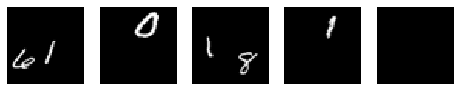

In [2]:
inpath = './air'
X_np, _ = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = torch.from_numpy(X_np)
def show_images(imgs):
    figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i + 1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(mnist[9:14])

In [3]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(50, 200)
        self.l2 = nn.Linear(200, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()

z_where_prior_loc = torch.tensor([3., 0., 0.])
z_where_prior_scale = torch.tensor([0.1, 1., 1.])
z_what_prior_loc = torch.zeros(50)
z_what_prior_scale = torch.ones(50)

def prior_step_sketch(t):
    # Sample object pose. This is a 3-dimensional vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(1, -1),
                                      z_where_prior_scale.expand(1, -1))
                              .to_event(1))

    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(1, -1),
                                     z_what_prior_scale.expand(1, -1))
                             .to_event(1))

    # Map code to pixel space using the neural network.
    y_att = decode(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, y_att)

    return y

In [4]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3])
    out = torch.cat((torch.zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

In [7]:
z_where = pyro.sample('z_where_{}'.format(1),
                          dist.Normal(z_where_prior_loc.expand(1, -1),
                                      z_where_prior_scale.expand(1, -1))
                              .to_event(1))

In [10]:
z_where

tensor([[ 3.0458,  0.1408, -0.5820]])

In [11]:
z_what = pyro.sample('z_what_{}'.format(1),
                         dist.Normal(z_what_prior_loc.expand(1, -1),
                                     z_what_prior_scale.expand(1, -1))
                             .to_event(1))

In [12]:
z_what

tensor([[ 2.1364,  0.0700,  0.4990,  0.8780,  0.3894,  1.4625,  0.4795, -0.5334,
          0.2284,  0.3241, -0.3112, -0.5620, -0.4835, -1.2721, -0.1740,  0.5541,
         -1.4928, -1.7644,  0.2942,  0.7973,  1.2642,  0.9355,  0.5455, -1.5374,
         -0.5636,  1.6446,  1.4502,  4.1015,  1.1182, -1.5668, -0.6990,  0.5744,
          0.6816,  1.5178, -0.0118,  0.9797, -1.0661,  1.7720, -0.2793, -0.2769,
          0.7489, -0.6435, -0.9518,  0.2715,  0.6716,  1.8500,  1.1910, -0.5899,
          0.9647, -1.5094]])

In [13]:
y_att = decode(z_what)

/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
n = y_att.size(0)

In [19]:
theta = expand_z_where(z_where)

In [20]:
theta

tensor([[[ 3.0458,  0.0000,  0.1408],
         [ 0.0000,  3.0458, -0.5820]]])

In [21]:
grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))

/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [23]:
grid.shape

torch.Size([1, 50, 50, 2])

In [25]:
out = grid_sample(y_att.view(n, 1, 20, 20), grid)

/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [26]:
out.shape

torch.Size([1, 1, 50, 50])

/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if 

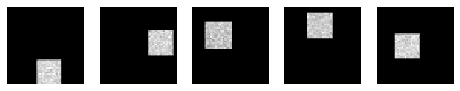

In [5]:
pyro.set_rng_seed(0)
samples = [prior_step_sketch(0)[0] for _ in range(5)]
show_images(samples)

In [ ]:
pyro.set_rng_seed(0)
def geom(num_trials=0):
    p = torch.tensor([0.5])
    x = pyro.sample('x{}'.format(num_trials), dist.Bernoulli(p))
    if x[0] == 1:
        return num_trials
    else:
        return geom(num_trials + 1)

# Generate some samples.
for _ in range(5):
    print('sampled {}'.format(geom()))

In [ ]:
def geom_prior(x, step=0):
    p = torch.tensor([0.5])
    i = pyro.sample('i{}'.format(step), dist.Bernoulli(p))
    if i[0] == 1:
        return x
    else:
        x = x + prior_step_sketch(step)
        return geom_prior(x, step + 1)

In [ ]:

pyro.set_rng_seed(4)
x_empty = torch.zeros(1, 50, 50)
samples = [geom_prior(x_empty)[0] for _ in range(5)]
show_images(samples)

In [ ]:
def prior_step(n, t, prev_x, prev_z_pres):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(0.5 * prev_z_pres)
                             .to_event(1))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(n, -1),
                                      z_where_prior_scale.expand(n, -1))
                              .mask(z_pres)
                              .to_event(1))

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(n, -1),
                                     z_what_prior_scale.expand(n, -1))
                             .mask(z_pres)
                             .to_event(1))

    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

In [ ]:
def prior(n):
    x = torch.zeros(n, 50, 50)
    z_pres = torch.ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

In [ ]:
pyro.set_rng_seed(1)
show_images(prior(5))


In [ ]:
def model(data):
    # Register network for optimization.
    pyro.module("decode", decode)
    with pyro.plate('data', data.size(0)) as indices:
        batch = data[indices]
        x = prior(batch.size(0)).view(-1, 50 * 50)
        sd = (0.3 * torch.ones(1)).expand_as(x)
        pyro.sample('obs', dist.Normal(x, sd).to_event(1),
                    obs=batch)

In [ ]:

def guide_step_basic(t, data, prev):

    # The RNN takes the images and choices from the previous step as input.
    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))

    # Compute parameters for all choices made this step, by passing
    # the RNN hidden start through another neural network.
    z_pres_p, z_where_loc, z_where_scale, z_what_loc, z_what_scale = predict_basic(h)

    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(z_pres_p * prev.z_pres))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_loc, z_where_scale))

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_loc, z_what_scale))

    return # values for next step

In [ ]:
rnn = nn.LSTMCell(2554, 256)

# Takes pixel intensities of the attention window to parameters (mean,
# standard deviation) of the distribution over the latent code,
# z_what.
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(400, 200)
        self.l2 = nn.Linear(200, 100)

    def forward(self, data):
        h = relu(self.l1(data))
        a = self.l2(h)
        return a[:, 0:50], softplus(a[:, 50:])

encode = Encoder()

# Takes the guide RNN hidden state to parameters of
# the guide distributions over z_where and z_pres.
class Predict(nn.Module):
    def __init__(self, ):
        super(Predict, self).__init__()
        self.l = nn.Linear(256, 7)

    def forward(self, h):
        a = self.l(h)
        z_pres_p = sigmoid(a[:, 0:1]) # Squish to [0,1]
        z_where_loc = a[:, 1:4]
        z_where_scale = softplus(a[:, 4:]) # Squish to >0
        return z_pres_p, z_where_loc, z_where_scale

predict = Predict()

def guide_step_improved(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)

    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(z_pres_p * prev.z_pres)
                             .to_event(1))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_loc, z_where_scale)
                              .to_event(1))

    # New. Crop a small window from the input.
    x_att = image_to_object(z_where, data)

    # Compute the parameter of the distribution over z_what
    # by passing the window through the encoder network.
    z_what_loc, z_what_scale = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_loc, z_what_scale)
                             .to_event(1))

    return # values for next step

In [ ]:
def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((torch.ones([1, 1]).type_as(z_where).expand(n, 1), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, 20, 20)))
    out = grid_sample(image.view(n, 1, 50, 50), grid)
    return out.view(n, -1)

In [ ]:
bl_rnn = nn.LSTMCell(2554, 256)
bl_predict = nn.Linear(256, 1)

# Use an RNN to compute the baseline value. This network takes the
# input images and the values samples so far as input.
def baseline_step(x, prev):
    rnn_input = torch.cat((x,
                           prev.z_where.detach(),
                           prev.z_what.detach(),
                           prev.z_pres.detach()), 1)
    bl_h, bl_c = bl_rnn(rnn_input, (prev.bl_h, prev.bl_c))
    bl_value = bl_predict(bl_h) * prev.z_pres
    return bl_value, bl_h, bl_c

In [ ]:
GuideState = namedtuple('GuideState', ['h', 'c', 'bl_h', 'bl_c', 'z_pres', 'z_where', 'z_what'])
def initial_guide_state(n):
    return GuideState(h=torch.zeros(n, 256),
                      c=torch.zeros(n, 256),
                      bl_h=torch.zeros(n, 256),
                      bl_c=torch.zeros(n, 256),
                      z_pres=torch.ones(n, 1),
                      z_where=torch.zeros(n, 3),
                      z_what=torch.zeros(n, 50))

def guide_step(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)

    # Here we compute the baseline value, and pass it to sample.
    baseline_value, bl_h, bl_c = baseline_step(data, prev)
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(z_pres_p * prev.z_pres)
                             .to_event(1),
                         infer=dict(baseline=dict(baseline_value=baseline_value.squeeze(-1))))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_loc, z_where_scale)
                              .mask(z_pres)
                              .to_event(1))

    x_att = image_to_object(z_where, data)

    z_what_loc, z_what_scale = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_loc, z_what_scale)
                             .mask(z_pres)
                             .to_event(1))

    return GuideState(h=h, c=c, bl_h=bl_h, bl_c=bl_c, z_pres=z_pres, z_where=z_where, z_what=z_what)

def guide(data):
    # Register networks for optimization.
    pyro.module('rnn', rnn),
    pyro.module('predict', predict),
    pyro.module('encode', encode),
    pyro.module('bl_rnn', bl_rnn)
    pyro.module('bl_predict', bl_predict)

    with pyro.plate('data', data.size(0), subsample_size=64) as indices:
        batch = data[indices]
        state = initial_guide_state(batch.size(0))
        steps = []
        for t in range(3):
            state = guide_step(t, batch, state)
            steps.append(state)
        return steps

In [ ]:
data = mnist.view(-1, 50 * 50)

svi = SVI(model,
          guide,
          optim.Adam({'lr': 1e-4}),
          loss=TraceGraph_ELBO())

for i in range(500):
    loss = svi.step(data)
    print('i={}, elbo={:.2f}'.format(i, loss / data.size(0)))